<h1 align=center><font size = 5>Madrid District Classification Analysis</font></h1>
<h2 align=center><font size = 3>Applied Datascience Capstone: Peer graded assignment</font></h2>
<h3 align=center><font size = 2>By Luis Andrade, August 2021</font></h3>

The objective of this study is to analyze the different patterns that characterize the different districts that conform the city of Madrid, Spain. Each of them have pros and cons depending on the people’s profile. There are people to prefer to live in a district full of fun and gastronomic options, while others prefer a quieter environment with more open-space recreational spaces. Some might pursuit one of these options assuming a high profile budget whereas others are only willing to afford economic places. Security could also be an issue for some if there were considerable flaws. We will figure out what aspects could impact more the average property value of each district and also, we will try to understand the similarities among them. To achieve these goals, we will mine some public data of Madrid, apply regression modeling to the mined data and perform some clustering techniques to group similar districts.

We are going to extract geographical, real estate, safety and venue information for each of Madrid’s district. We will mine each database and integrate the different types of information to better understand each district, find correlation of the different aspects and try to group similar districts and determine in what they are similar.

To begin this project, we will need the following Python libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup #Webscraping library

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import linera model module
from sklearn import linear_model

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist #library to measure Euclidean distances of clusters

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### MADRID GEOGRAPHICAL DATA MINING

In order to perform our District analysis of Madrid, Spain, we need to collect information aboout tits districts. The data can be found from different public sources.

We are going to use as first source a Wikipedia page that describes each <a href= "https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid">Madrid district and neighborhoods</a>. We are going to scrap this page by using Beautiful Soup library in order to extract the corresponding table and arrange it as dataframe. 

As first step, we define the URL address of the page we are about to scrap:

In [2]:
url = 'https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid'

Then we download the webpage in text format and extract the table information. In this case, the page only has one table

In [3]:
text_req = requests.get(url).text #Download the web page content in text format
soup = BeautifulSoup(text_req, 'html5lib') #Create soup oobject
table = soup.find('table') #Find html tables, represented by <table> tag

Next, we populate a table list with the information we need: District numbers, district names and neighborhood names. Then this table will be transformed into a dataframe

In [4]:
#Create empty list that will be populated with dictionaries
madrid_districts=[]

for row in table.findAll('tr'):
    cell={}
    col = row.find_all('td')
    #Omit records with not assigned information
    if (col != []):
        # Extract district numbers as text from the first column
        cell['DistNumber'] = col[0].text.strip()
        # Extract district names as text from the second column
        cell['District'] = col[1].text.strip()
        # Extract neighborhood from the 7th column and replace some separators with comma and empty
        cell['Neighborhood'] = col[6].text.replace(' (','').replace('\d+','').replace(')',',').replace(',\n','')
        madrid_districts.append(cell)

madrid_df = pd.DataFrame(madrid_districts)
madrid_df        

,DistNumber,District,Neighborhood
0,1,Centro,"Palacio11,Embajadores12,Cortes13,Justicia14,Un..."
1,2,Arganzuela,"Imperial21,Acacias22,Chopera23,Legazpi24,Delic..."
2,3,Retiro,"Pacífico31,Adelfas32,Estrella33,Ibiza34,Jerón..."
3,4,Salamanca,"Recoletos41,Goya42,Fuente del Berro43,Guindale..."
4,5,Chamartín,"El Viso51,Prosperidad52,Ciudad Jardín53,Hispan..."
5,6,Tetuán,"Bellas Vistas61,Cuatro Caminos62,Castillejos63..."
6,7,Chamberí,"Gaztambide71,Arapiles72,Trafalgar73,Almagro74,..."
7,8,Fuencarral-El Pardo,"El Pardo81,Fuentelarreina82,Peñagrande83,Pilar..."
8,9,Moncloa-Aravaca,"Casa de Campo91,Argüelles92,Ciudad Universitar..."
9,10,Latina,"Los Cármenes101,Puerta del Ángel102,Lucero103,..."


Madrid neighborhood table needs more pre processing. We still need to delete numbers within the neighborhood names

In [5]:
# Delete numbers from the Neighborhood column
madrid_df['Neighborhood'] = madrid_df['Neighborhood'].str.replace('\d+','').replace(' ,',',')
# Turn 'Neighborhood' column text to list values separated by ","
madrid_df['Neighborhood'] = madrid_df['Neighborhood'].str.split('[,]')
madrid_df

,DistNumber,District,Neighborhood
0,1,Centro,"[Palacio, Embajadores, Cortes, Justicia, Unive..."
1,2,Arganzuela,"[Imperial, Acacias, Chopera, Legazpi, Delicias..."
2,3,Retiro,"[ Pacífico, Adelfas, Estrella, Ibiza, Jerónimo..."
3,4,Salamanca,"[Recoletos, Goya, Fuente del Berro, Guindalera..."
4,5,Chamartín,"[El Viso, Prosperidad, Ciudad Jardín, Hispanoa..."
5,6,Tetuán,"[Bellas Vistas, Cuatro Caminos, Castillejos, A..."
6,7,Chamberí,"[Gaztambide, Arapiles, Trafalgar, Almagro, Río..."
7,8,Fuencarral-El Pardo,"[El Pardo, Fuentelarreina, Peñagrande, Pilar, ..."
8,9,Moncloa-Aravaca,"[Casa de Campo, Argüelles, Ciudad Universitari..."
9,10,Latina,"[Los Cármenes, Puerta del Ángel, Lucero, Aluch..."


We could go further and divide this district table by indiviual neighborhoods, in separate rows. This could let more detailed studies. Nonethelese, the scope of this analysis is limited to districts given that the data we colected is summarized by districts and not by neighborhoods. However, as excercise, we include the codes and see the result of the `explode` method to divide the Neighborhood values into different rows: 

In [6]:
madrid_neigh_table = madrid_df
# Convert neighborhood list values to new rows
madrid_neigh_table = madrid_neigh_table.explode('Neighborhood')
# Discard any row indicating new space jump "\n"
#madrid_neigh_table = madrid_neigh_table[madrid_neigh_table.Neighborhood != '\n'].reset_index()
print('Madrid has {} districts and {} neighborhoods'.format(len(madrid_neigh_table['District'].unique()),len(madrid_neigh_table['Neighborhood'].unique())))
madrid_neigh_table

Madrid has 21 districts and 131 neighborhoods


,DistNumber,District,Neighborhood
0,1,Centro,Palacio
0,1,Centro,Embajadores
0,1,Centro,Cortes
0,1,Centro,Justicia
0,1,Centro,Universidad
0,1,Centro,Sol
1,2,Arganzuela,Imperial
1,2,Arganzuela,Acacias
1,2,Arganzuela,Chopera
1,2,Arganzuela,Legazpi


***Coordinate retrieval for each district***

Now with the aid of Nominatim module of Geopy library module we are going to get the Madrid central coordinates that will be used to center the following maps

In [7]:
address = 'Madrid, Spain'

geolocator = Nominatim(user_agent="MAD_explorer")
location = geolocator.geocode(address)
MADlat = location.latitude
MADlong = location.longitude
print('The geograpical coordinates of Madrid, Spain are {}, {}.'.format(MADlat, MADlong))

The geograpical coordinates of Madrid, Spain are 40.4167047, -3.7035825.


Then, also with Nominatim, we are going to extract the coordinates of each district geographical center. These coordinates will be subsequently added to the district dataframe, from where we will later plot in a map through the Folium library each district marker according to its coordinates. These markers will later be used to map district clustering results.

In [8]:
neigh_lat=[]
neigh_long=[]
for i in range(len(madrid_df)):
    locat = madrid_df.iloc[i,1]
    addr = locat + ', Madrid, Spain'
    
    geolocator = Nominatim(user_agent="MAD_explorer")
    location = geolocator.geocode(addr)
    lat = location.latitude
    long = location.longitude
    neigh_lat.append(lat)
    neigh_long.append(long)

Now we can append the retreived coordinate information to our built district dataframe

In [9]:
madrid_df['LAT'] = neigh_lat
madrid_df['LONG'] = neigh_long
madrid_df

,DistNumber,District,Neighborhood,LAT,LONG
0,1,Centro,"[Palacio, Embajadores, Cortes, Justicia, Unive...",40.417653,-3.707914
1,2,Arganzuela,"[Imperial, Acacias, Chopera, Legazpi, Delicias...",40.396954,-3.697289
2,3,Retiro,"[ Pacífico, Adelfas, Estrella, Ibiza, Jerónimo...",40.411150,-3.676057
3,4,Salamanca,"[Recoletos, Goya, Fuente del Berro, Guindalera...",40.427045,-3.680602
4,5,Chamartín,"[El Viso, Prosperidad, Ciudad Jardín, Hispanoa...",40.458987,-3.676129
5,6,Tetuán,"[Bellas Vistas, Cuatro Caminos, Castillejos, A...",40.460578,-3.698281
6,7,Chamberí,"[Gaztambide, Arapiles, Trafalgar, Almagro, Río...",40.436247,-3.703830
7,8,Fuencarral-El Pardo,"[El Pardo, Fuentelarreina, Peñagrande, Pilar, ...",40.556346,-3.778591
8,9,Moncloa-Aravaca,"[Casa de Campo, Argüelles, Ciudad Universitari...",40.439495,-3.744204
9,10,Latina,"[Los Cármenes, Puerta del Ángel, Lucero, Aluch...",40.403532,-3.736152


Once we have the coordinates for each district, we then proceed to plot each District center as marker with district and neighborhood information through the Foilum library:

In [13]:
# create map of Madrid using as refrence its central latitude and longitude values
map_madrid = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# add markers to map
for lat, lng, district, neighborhood in zip(madrid_df['LAT'], madrid_df['LONG'], madrid_df['District'], madrid_df['Neighborhood']):
    label = '{}, {}'.format(district.upper(), neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

This intercative map allows of to spatially recognize each district and corresponding neighborhoods locations

### REAL ESTATE VALUES

Our analysis include the impact of real estate values in the district characcterization. Our first steps in this domain is to proceeded to extract average square meter price per district from two web sources:

- Mid 2021 average district prices  from <a href= "https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/">Idealista</a> real estate platform
- Octuber 2019 average district prices from an <a href="https://cincodias.elpais.com/cincodias/2019/10/11/album/1570794955_313018.html#foto_gal_2">article</a> of the media site “Cinco Días”, part of the prestigious El País Spanish journal.


#### *2021 square meter averages from Idealista.com:*
In the <a href= "https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/">Idealista</a> web page that we used as reference there was a table not in text format that was copied and pasted in an Excel spreadsheet that was subsequently imported to this notebook

In [14]:
madrid_sqm_idealista = pd.read_excel('Idealista-Madrid-jul2021.xlsx', header=0)
madrid_sqm_idealista

,Localización,Precio m2 jul 2021,Variación mensual,Variación trimestral,Variación anual,Máximo histórico,Variación máximo
0,Madrid,3.760 €/m2,"+ 0,1 %","+ 1,2 %","+ 2,0 %",3.822 €/m2 jul 2019,"- 1,6 %"
1,Arganzuela,4.000 €/m2,"- 1,4 %","+ 1,7 %","+ 2,3 %",4.096 €/m2 jul 2019,"- 2,4 %"
2,Barajas,3.225 €/m2,"+ 1,7 %","+ 1,0 %","+ 3,2 %",3.663 €/m2 mar 2009,"- 12,0 %"
3,Carabanchel,2.123 €/m2,"- 1,5 %","+ 0,9 %","- 1,3 %",3.173 €/m2 jun 2007,"- 33,1 %"
4,Centro,4.793 €/m2,"+ 0,9 %","- 0,3 %","- 3,8 %",5.096 €/m2 ene 2020,"- 5,9 %"
5,Chamartín,5.137 €/m2,"- 0,3 %","+ 0,8 %","+ 0,5 %",5.216 €/m2 nov 2018,"- 1,5 %"
6,Chamberí,5.347 €/m2,"+ 0,8 %","+ 2,0 %","+ 0,2 %",5.432 €/m2 mayo 2020,"- 1,6 %"
7,Ciudad Lineal,3.004 €/m2,"+ 0,6 %","+ 2,4 %","+ 2,1 %",3.578 €/m2 oct 2007,"- 16,0 %"
8,Fuencarral,3.504 €/m2,"- 0,6 %","- 0,5 %","- 0,8 %",3.726 €/m2 mayo 2008,"- 6,0 %"
9,Hortaleza,3.812 €/m2,"+ 1,2 %","+ 3,4 %","+ 2,7 %",3.812 €/m2 jul 2021,"0,0 %"


This table needs some data selection and preprocessing in order to stay with the variables and data we need with the proper data type, integer in this case:

In [15]:
#Remain with the district and sqr meter price column. Remove all the other columns
madrid_sqm_idealista.drop(madrid_sqm_idealista.iloc[:,2:7], axis=1, inplace=True)
#Rename column names to shorter and English names
colnames = ['District','SQMprice2021']
madrid_sqm_idealista.set_axis(colnames, axis=1, inplace=True)
#Remove non numeric characters from the sqr meter price column
madrid_sqm_idealista['SQMprice2021']= madrid_sqm_idealista['SQMprice2021'].str.replace(' €/m2','').str.replace('.','')
#Change sqr meter price column data type to integer
madrid_sqm_idealista['SQMprice2021'] = madrid_sqm_idealista['SQMprice2021'].astype(int)
#Check column data types
print(madrid_sqm_idealista.dtypes)
madrid_sqm_idealista

District        object
SQMprice2021     int32
dtype: object


,District,SQMprice2021
0,Madrid,3760
1,Arganzuela,4000
2,Barajas,3225
3,Carabanchel,2123
4,Centro,4793
5,Chamartín,5137
6,Chamberí,5347
7,Ciudad Lineal,3004
8,Fuencarral,3504
9,Hortaleza,3812


#### *2019 reference prices from El País - Cinco Días:*
The quoted article had a series of images with district average prices of different Spanish cities. We only focused on the image with the Madrid table![Madrid image:](https://d500.epimg.net/cincodias/imagenes/2019/10/11/album/1570794955_313018_1570887923_album_normal.jpg)


From this image we extracted the district and price information, which we placed into an Excel spreadsheet that was later imported in our project notebook

In [16]:
madrid_sqm_5dias = pd.read_excel('Madrid_M2_Cincodias.xlsx')
print(madrid_sqm_5dias.dtypes)
madrid_sqm_5dias

DISTRITO     object
PRECIO_M2     int64
dtype: object


,DISTRITO,PRECIO_M2
0,Arganzuela,3878
1,Barajas,3001
2,Carabanchel,2156
3,Centro,4621
4,Chamartín,4468
5,Chamberí,4905
6,Ciudad Lineal,2883
7,Fuencarral,3248
8,Hortaleza,3154
9,Latina,2183


In [17]:
#Rename columns to assure same 'District' name like the rest of the dataframes
colnames1= ['District','SQMprice2019']
madrid_sqm_5dias.set_axis(colnames1, axis=1, inplace=True)
madrid_sqm_5dias

,District,SQMprice2019
0,Arganzuela,3878
1,Barajas,3001
2,Carabanchel,2156
3,Centro,4621
4,Chamartín,4468
5,Chamberí,4905
6,Ciudad Lineal,2883
7,Fuencarral,3248
8,Hortaleza,3154
9,Latina,2183


Now we merge the tables to gather both Idealista (2021) and CincoDías (2019) prices

In [18]:
madrid_sqm = pd.merge(madrid_sqm_idealista, madrid_sqm_5dias, on='District')
madrid_sqm

,District,SQMprice2021,SQMprice2019
0,Arganzuela,4000,3878
1,Barajas,3225,3001
2,Carabanchel,2123,2156
3,Centro,4793,4621
4,Chamartín,5137,4468
5,Chamberí,5347,4905
6,Ciudad Lineal,3004,2883
7,Fuencarral,3504,3248
8,Hortaleza,3812,3154
9,Latina,2254,2183


Calculate more attributes from the given area prices:
- *Variation*: Proportional variation of sqm price relative to 2019 values
- *Mean SQM price*: Average of 2019 and 2021 square meter (SQM) prices
- *Normalized to mean SQM*: District SQM average divided by the global Madrid mean in order to have relative references in relation to the mean city area price.
- *Linear Normalization*: District price  minus the minimum price divided by the price range. This parameter works as input for future classification exercises. The output values range from 0 (minimum price) to 1 (maximum price).

In [19]:
madrid_sqm['Var'] = np.subtract(madrid_sqm['SQMprice2021'], madrid_sqm['SQMprice2019'], axis=1)/madrid_sqm['SQMprice2019']
madrid_sqm['meanSQM'] = np.mean(madrid_sqm[['SQMprice2021','SQMprice2019']], axis=1)
madrid_sqm['SQMnormMean'] = madrid_sqm['meanSQM']/np.mean(madrid_sqm['meanSQM'],axis=0)
madrid_sqm['SQMlinNorm'] = (madrid_sqm['meanSQM']-np.min(madrid_sqm['meanSQM']))/(np.max(madrid_sqm['meanSQM'])-np.min(madrid_sqm['meanSQM']))
print('2019-2021 SQM price variations ranged from {:.2f}% to {:.2f}% with {:.2f}% as mean variation values'.format(np.min(madrid_sqm['Var'])*100,np.max(madrid_sqm['Var'])*100,np.mean(madrid_sqm['Var'],axis=0)*100))
print('SQM mean prices ranged from {:.0f}€/m2 to {:.0f}€/m2 with {:.0f}€/m2 as mean city SQM price'.format(np.min(madrid_sqm['meanSQM']),np.max(madrid_sqm['meanSQM']),np.mean(madrid_sqm['meanSQM'],axis=0)))
madrid_sqm

2019-2021 SQM price variations ranged from -1.53% to 20.86% with 7.89% as mean variation values
SQM mean prices ranged from 1694€/m2 to 5606€/m2 with 3258€/m2 as mean city SQM price


,District,SQMprice2021,SQMprice2019,Var,meanSQM,SQMnormMean,SQMlinNorm
0,Arganzuela,4000,3878,0.031460,3939.0,1.208997,0.573894
1,Barajas,3225,3001,0.074642,3113.0,0.955473,0.362695
2,Carabanchel,2123,2156,-0.015306,2139.5,0.656677,0.113782
3,Centro,4793,4621,0.037221,4707.0,1.444720,0.770263
4,Chamartín,5137,4468,0.149731,4802.5,1.474032,0.794682
5,Chamberí,5347,4905,0.090112,5126.0,1.573323,0.877397
6,Ciudad Lineal,3004,2883,0.041970,2943.5,0.903449,0.319356
7,Fuencarral,3504,3248,0.078818,3376.0,1.036196,0.429941
8,Hortaleza,3812,3154,0.208624,3483.0,1.069037,0.457300
9,Latina,2254,2183,0.032524,2218.5,0.680924,0.133981


In general, Madrid properties were raised in value 7.89%. Only one district, Carabanchel (SW MAdrid) had a slightly negative variation. 

Now we proceed to modify some district names to assure matches when we merge these real estate values with other attribute tables 

In [20]:
madrid_sqm = madrid_sqm.replace({'District':{'Fuencarral':'Fuencarral-El Pardo',
                                             'Moncloa':'Moncloa-Aravaca',
                                             'San Blas':'San Blas-Canillejas'}})
madrid_sqm

,District,SQMprice2021,SQMprice2019,Var,meanSQM,SQMnormMean,SQMlinNorm
0,Arganzuela,4000,3878,0.031460,3939.0,1.208997,0.573894
1,Barajas,3225,3001,0.074642,3113.0,0.955473,0.362695
2,Carabanchel,2123,2156,-0.015306,2139.5,0.656677,0.113782
3,Centro,4793,4621,0.037221,4707.0,1.444720,0.770263
4,Chamartín,5137,4468,0.149731,4802.5,1.474032,0.794682
5,Chamberí,5347,4905,0.090112,5126.0,1.573323,0.877397
6,Ciudad Lineal,3004,2883,0.041970,2943.5,0.903449,0.319356
7,Fuencarral-El Pardo,3504,3248,0.078818,3376.0,1.036196,0.429941
8,Hortaleza,3812,3154,0.208624,3483.0,1.069037,0.457300
9,Latina,2254,2183,0.032524,2218.5,0.680924,0.133981


Finally, we will stay with mean square-meter values and normalized versions for the next steps. We also generate a sorted value version that will act as input for the District are price bar plot

In [21]:
madrid_sqm_short = madrid_sqm[['District','meanSQM','SQMnormMean','SQMlinNorm']]
madrid_sqm_short_sort = madrid_sqm_short.sort_values('meanSQM', ascending=False).reset_index()
madrid_sqm_short_sort

,index,District,meanSQM,SQMnormMean,SQMlinNorm
0,14,Salamanca,5605.5,1.720496,1.000000
1,5,Chamberí,5126.0,1.573323,0.877397
2,4,Chamartín,4802.5,1.474032,0.794682
3,3,Centro,4707.0,1.444720,0.770263
4,13,Retiro,4474.5,1.373358,0.710816
5,0,Arganzuela,3939.0,1.208997,0.573894
6,10,Moncloa-Aravaca,3806.0,1.168176,0.539887
7,16,Tetuán,3548.5,1.089141,0.474048
8,8,Hortaleza,3483.0,1.069037,0.457300
9,7,Fuencarral-El Pardo,3376.0,1.036196,0.429941


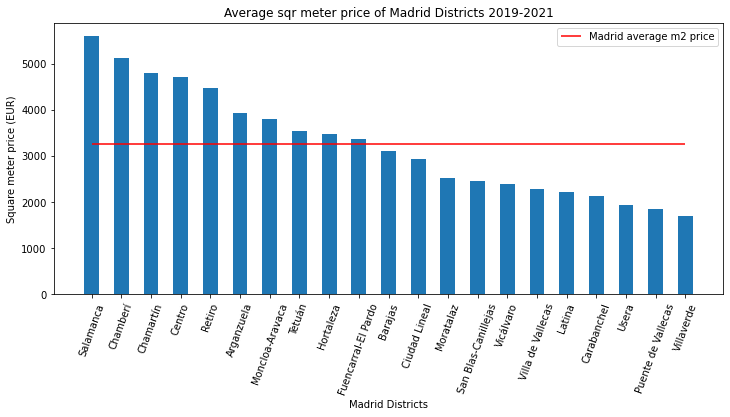

In [22]:
xmin=madrid_sqm_short_sort['District'].iloc[0]
xmax=madrid_sqm_short_sort['District'].iloc[-1]

fig = plt.figure(figsize=(12,5))
plt.bar(madrid_sqm_short_sort['District'], madrid_sqm_short_sort['meanSQM'], width=0.5)
plt.xlabel('Madrid Districts')
plt.xticks(rotation=70)
plt.hlines(y=np.mean(madrid_sqm['meanSQM']),xmin=xmin,xmax=xmax,color='r',linestyles='-',label='Madrid average m2 price')
plt.ylabel('Square meter price (EUR)')
plt.title('Average sqr meter price of Madrid Districts 2019-2021')
plt.legend()
plt.show()

We have 10 districts (48%) above the average unit area price and 11 (52%) bellow. The price variation per district goes gradually, with some minor jumps and plateaus. At least in Madrid we don’t see important gaps of price ranges which in turn mean that there are options for almost all budgets between 1700 and 5600 euros/m2.

Now we proceed to plot our average prices in a *Choropleth* map. To achieve this we firs need to get the district boundaries. We obtained them from a geojson file available in a <a href='https://team.carto.com/u/jsanz/tables/distritos/public'>Carto.com</a> address. Before loading the file to our notebook we made sure to identify the feature name acting as key and that the districts had the same names of our dataframes.

In [23]:
madrid_geo = 'distritos.geojson' #From https://team.carto.com/u/jsanz/tables/distritos/public

In [24]:
mad_map_sqm = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# generate choropleth map using the average square meter price per district of Madrid as color attribute
mad_map_sqm.choropleth(
    geo_data=madrid_geo,
    data=madrid_sqm_short,
    columns=['District', 'meanSQM'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average m2 value',
    reset = True #run if you perform more than one test
)

# display map
mad_map_sqm

C:\programs\anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


Downtown districts turn to be the most expensive areas. On the other hand, the southern and eastern districts have the lowest prices. The northern and western districts offer intermediate prices.

Now we can merge this real estate values to our main dataframe by matching the corresponding districts. We can apply an inner join method or a left join one using the main dataframe as reference on the left side.

In [25]:
meanSQM = madrid_sqm['meanSQM']
SQM_normMean = madrid_sqm['SQMnormMean']
SQM_linNorm = madrid_sqm['SQMlinNorm']

madrid_df = pd.merge(madrid_df, madrid_sqm_short, how='left', on='District')
madrid_df

,DistNumber,District,Neighborhood,LAT,LONG,meanSQM,SQMnormMean,SQMlinNorm
0,1,Centro,"[Palacio, Embajadores, Cortes, Justicia, Unive...",40.417653,-3.707914,4707.0,1.444720,0.770263
1,2,Arganzuela,"[Imperial, Acacias, Chopera, Legazpi, Delicias...",40.396954,-3.697289,3939.0,1.208997,0.573894
2,3,Retiro,"[ Pacífico, Adelfas, Estrella, Ibiza, Jerónimo...",40.411150,-3.676057,4474.5,1.373358,0.710816
3,4,Salamanca,"[Recoletos, Goya, Fuente del Berro, Guindalera...",40.427045,-3.680602,5605.5,1.720496,1.000000
4,5,Chamartín,"[El Viso, Prosperidad, Ciudad Jardín, Hispanoa...",40.458987,-3.676129,4802.5,1.474032,0.794682
5,6,Tetuán,"[Bellas Vistas, Cuatro Caminos, Castillejos, A...",40.460578,-3.698281,3548.5,1.089141,0.474048
6,7,Chamberí,"[Gaztambide, Arapiles, Trafalgar, Almagro, Río...",40.436247,-3.703830,5126.0,1.573323,0.877397
7,8,Fuencarral-El Pardo,"[El Pardo, Fuentelarreina, Peñagrande, Pilar, ...",40.556346,-3.778591,3376.0,1.036196,0.429941
8,9,Moncloa-Aravaca,"[Casa de Campo, Argüelles, Ciudad Universitari...",40.439495,-3.744204,3806.0,1.168176,0.539887
9,10,Latina,"[Los Cármenes, Puerta del Ángel, Lucero, Aluch...",40.403532,-3.736152,2218.5,0.680924,0.133981


### SECURITY INCIDENTS PER DISTRICT

From the web site <a href="https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=bffff1d2a9fdb410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default">datos.madrid.es</a> we downloaded monthly reports of police interventions per districts that are separated per categories. We downloaded 6 spreadsheet files with reports from January to June 2021. These files are then uploaded to our project notebook.

We upload the first file and display it to check any issue to adjust or modify. In this case, we get rid off the samples related to unassigned districts and totals, since we only want district identified cases and we are not going to totalize numbers yet.

In [28]:
security_01 = pd.read_excel('Datos_Enero_2021.xlsx', sheet_name='SEGURIDAD', header=2)
security_01.drop(security_01[security_01['DISTRITOS']=='SIN DISTRITO ASIGNADO'].index, inplace=True)
security_01.drop(security_01[security_01['DISTRITOS']=='TOTAL'].index, inplace=True)
security_01.head(10)

,DISTRITOS,RELACIONADAS CON LAS PERSONAS,RELACIONADAS CON EL PATRIMONIO,POR TENENCIA DE ARMAS,POR TENENCIA DE DROGAS,POR CONSUMO DE DROGAS
0,CENTRO,19,43,17,32,8
1,ARGANZUELA,4,10,1,3,1
2,RETIRO,1,4,0,5,1
3,SALAMANCA,3,49,0,11,0
4,CHAMARTÍN,3,6,1,7,2
5,TETUÁN,14,13,1,3,6
6,CHAMBERÍ,4,13,3,7,2
7,FUENCARRAL - EL PARDO,4,10,0,10,1
8,MONCLOA - ARAVACA,23,17,0,4,3
9,LATINA,8,12,9,11,2


We repeat the previous steps for the second table and once again display to check

In [29]:
security_02 = pd.read_excel('DatosFebrero_2021.xlsx', sheet_name='SEGURIDAD', header=2)
security_02.drop(security_02[security_02['DISTRITOS']=='SIN DISTRITO ASIGNADO'].index, inplace=True)
security_02.drop(security_02[security_02['DISTRITOS']=='TOTAL'].index, inplace=True)
security_02.tail(10)

,DISTRITOS,RELACIONADAS CON LAS PERSONAS,RELACIONADAS CON EL PATRIMONIO,POR TENENCIA DE ARMAS,POR TENENCIA DE DROGAS,POR CONSUMO DE DROGAS
11,USERA,17,24,0,10,5
12,PUENTE DE VALLECAS,30,18,6,25,3
13,MORATALAZ,6,5,0,5,1
14,CIUDAD LINEAL,15,20,2,25,6
15,HORTALEZA,3,15,8,35,8
16,VILLAVERDE,8,16,0,18,4
17,VILLA DE VALLECAS,12,10,4,27,1
18,VICÁLVARO,8,5,0,0,0
19,SAN BLAS - CANILLEJAS,13,21,1,31,2
20,BARAJAS,6,17,0,8,1


Now we upload the rest of the tables, having confidence that the previus steps work as well for these. Should any execution problem occur, we proceed to upload and check step by step each table to correct the cause of the problems

In [30]:
security_03 = pd.read_excel('Datos_Marzo_2021.xlsx', sheet_name='SEGURIDAD', header=2)
security_03.drop(security_03[security_03['DISTRITOS']=='SIN DISTRITO ASIGNADO'].index, inplace=True)
security_03.drop(security_03[security_03['DISTRITOS']=='TOTAL'].index, inplace=True)

security_04 = pd.read_excel('DatosAbril_2021.xlsx', sheet_name='SEGURIDAD', header=2)
security_04.drop(security_04[security_04['DISTRITOS']=='SIN DISTRITO ASIGNADO'].index, inplace=True)
security_04.drop(security_04[security_04['DISTRITOS']=='TOTAL'].index, inplace=True)

security_05 = pd.read_excel('DatosMayo_2021.xlsx', sheet_name='SEGURIDAD', header=2)
security_05.drop(security_05[security_05['DISTRITOS']=='SIN DISTRITO ASIGNADO'].index, inplace=True)
security_05.drop(security_05[security_05['DISTRITOS']=='TOTAL'].index, inplace=True)

security_06 = pd.read_excel('DatosJunio_2021.xlsx', sheet_name='SEGURIDAD', header=2)
security_06.drop(security_06[security_06['DISTRITOS']=='SIN DISTRITO ASIGNADO'].index, inplace=True)
security_06.drop(security_06[security_06['DISTRITOS']=='TOTAL'].index, inplace=True)

Now that we have all the security tables uploaded we then proceed to the totalization steps. To achieve this, I like to use the Numpy functionalities. 

We start with the dataframe conversions to Numpy arrays, excluding the district column, only numeric value features. Once we have array variables for each month security dataframe, we proceed to sum them and save it as a total variable:

In [32]:
january = np.array(security_01.iloc[:,1:6])
january

array([[19, 43, 17, 32,  8],
       [ 4, 10,  1,  3,  1],
       [ 1,  4,  0,  5,  1],
       [ 3, 49,  0, 11,  0],
       [ 3,  6,  1,  7,  2],
       [14, 13,  1,  3,  6],
       [ 4, 13,  3,  7,  2],
       [ 4, 10,  0, 10,  1],
       [23, 17,  0,  4,  3],
       [ 8, 12,  9, 11,  2],
       [27, 31,  4,  9,  6],
       [30, 20,  1,  8,  2],
       [25, 29,  3,  8,  0],
       [ 5,  2,  0,  1,  1],
       [15, 14,  1, 14,  5],
       [ 4, 14,  7, 26,  9],
       [14, 11,  1, 13,  2],
       [16, 10,  3, 20,  0],
       [ 7,  3,  0,  0,  0],
       [11,  9,  3, 11,  1],
       [ 5,  5,  0,  5,  2]], dtype=int64)

In [33]:
february = np.array(security_02.iloc[:,1:6])
march = np.array(security_03.iloc[:,1:6])
april = np.array(security_04.iloc[:,1:6])
may = np.array(security_05.iloc[:,1:6])
june = np.array(security_06.iloc[:,1:6])

total=[]
total = january+february+march+april+may+june
total

array([[203, 366,  72, 416,  77],
       [ 34,  50,  14,  37,  25],
       [ 21,  28,   5,  88,  18],
       [ 44, 274,  12, 139,  11],
       [ 31,  49,   9,  88,  17],
       [109, 114,  15,  62,  18],
       [ 58,  63,  10,  98,  15],
       [ 40,  44,   7, 112,   6],
       [147, 121,   9,  92,  17],
       [106,  83,  20, 204,  46],
       [208, 171,  18, 113,  27],
       [120, 134,   3,  48,  14],
       [194, 162,  28, 192,   5],
       [ 44,  41,   2,  24,   3],
       [108, 101,  12, 149,  38],
       [ 36,  57,  32, 214,  52],
       [116, 110,   5, 119,  24],
       [108,  91,  18, 109, 147],
       [ 67,  52,   0,   7,   2],
       [111, 126,  13, 108,   8],
       [ 43,  66,   1,  60,  23]], dtype=int64)

Now we save the total array to a new dataframe

In [34]:
total_security=[]
column_names = list(security_01.columns[1:6])
total_security=pd.DataFrame(data=total, columns=column_names)
total_security

,RELACIONADAS CON LAS PERSONAS,RELACIONADAS CON EL PATRIMONIO,POR TENENCIA DE ARMAS,POR TENENCIA DE DROGAS,POR CONSUMO DE DROGAS
0,203,366,72,416,77
1,34,50,14,37,25
2,21,28,5,88,18
3,44,274,12,139,11
4,31,49,9,88,17
5,109,114,15,62,18
6,58,63,10,98,15
7,40,44,7,112,6
8,147,121,9,92,17
9,106,83,20,204,46


It is time to retrieve the District column from a previous dataframe and rename the rest of the columns to shorter and English language names that anyone not familiarized with Spanish can  understand:

In [35]:
total_security['DISTRITOS'] = madrid_df['District']
total_security.insert(0,'DISTRITOS',total_security.pop('DISTRITOS'))
new_colnames = ['District','People','Assets','Weapons','DrugPos','DrugCons']
total_security.set_axis(new_colnames, axis=1, inplace=True)
total_security

,District,People,Assets,Weapons,DrugPos,DrugCons
0,Centro,203,366,72,416,77
1,Arganzuela,34,50,14,37,25
2,Retiro,21,28,5,88,18
3,Salamanca,44,274,12,139,11
4,Chamartín,31,49,9,88,17
5,Tetuán,109,114,15,62,18
6,Chamberí,58,63,10,98,15
7,Fuencarral-El Pardo,40,44,7,112,6
8,Moncloa-Aravaca,147,121,9,92,17
9,Latina,106,83,20,204,46


In order to simply the categories, we group the first three categories as security incidents or “crimes”, a short alias to better handle column names, and the drug reports as “drugs” categories. In other words, we sum person, asset and weapon cases as “crimes” and drug possession and consumption cases as “drugs”. 

Also, we generate proportional calculations of criminal and drug cases compared to their corresponding category totals. These proportions will serve as inputs for the classification steps.

In [37]:
total_security['Crimes'] = np.sum(total_security[['People','Assets','Weapons']], axis=1)
total_security['Drugs'] = np.sum(total_security[['DrugPos','DrugCons']], axis=1)
total_security['Total'] = np.sum(total_security[['Crimes','Drugs']], axis=1)
total_security['CrimesProp'] = total_security['Crimes'] / np.sum(total_security['Crimes'], axis=0)
total_security['DrugsProp'] = total_security['Drugs'] / np.sum(total_security['Drugs'], axis=0)
total_security

,District,People,Assets,Weapons,DrugPos,DrugCons,Crimes,Drugs,Total,CrimesProp,DrugsProp
0,Centro,203,366,72,416,77,641,493,1134,0.140694,0.160482
1,Arganzuela,34,50,14,37,25,98,62,160,0.021510,0.020182
2,Retiro,21,28,5,88,18,54,106,160,0.011853,0.034505
3,Salamanca,44,274,12,139,11,330,150,480,0.072432,0.048828
4,Chamartín,31,49,9,88,17,89,105,194,0.019535,0.034180
5,Tetuán,109,114,15,62,18,238,80,318,0.052239,0.026042
6,Chamberí,58,63,10,98,15,131,113,244,0.028753,0.036784
7,Fuencarral-El Pardo,40,44,7,112,6,91,118,209,0.019974,0.038411
8,Moncloa-Aravaca,147,121,9,92,17,277,109,386,0.060799,0.035482
9,Latina,106,83,20,204,46,209,250,459,0.045874,0.081380


For plotting purposes, we sort the records based on total criminal + drug cases:

In [38]:
total_security_sort = total_security.sort_values('Total').reset_index()
total_security_sort

,index,District,People,Assets,Weapons,DrugPos,DrugCons,Crimes,Drugs,Total,CrimesProp,DrugsProp
0,13,Moratalaz,44,41,2,24,3,87,27,114,0.019096,0.008789
1,18,Vicálvaro,67,52,0,7,2,119,9,128,0.026119,0.002930
2,1,Arganzuela,34,50,14,37,25,98,62,160,0.021510,0.020182
3,2,Retiro,21,28,5,88,18,54,106,160,0.011853,0.034505
4,20,Barajas,43,66,1,60,23,110,83,193,0.024144,0.027018
5,4,Chamartín,31,49,9,88,17,89,105,194,0.019535,0.034180
6,7,Fuencarral-El Pardo,40,44,7,112,6,91,118,209,0.019974,0.038411
7,6,Chamberí,58,63,10,98,15,131,113,244,0.028753,0.036784
8,5,Tetuán,109,114,15,62,18,238,80,318,0.052239,0.026042
9,11,Usera,120,134,3,48,14,257,62,319,0.056409,0.020182


We are going to represent the police interventions of crime category and drug category as horizontal bar plot

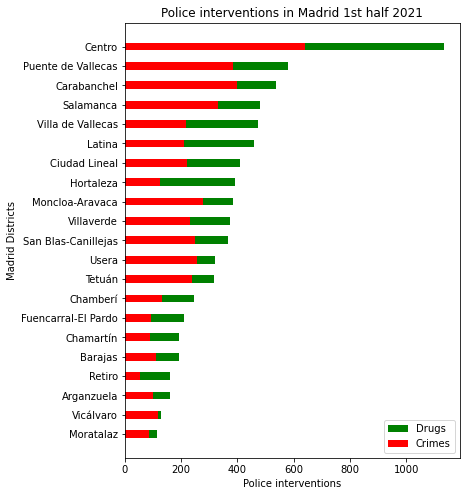

In [39]:
width=0.4
y = total_security_sort['District']

fig, ax = plt.subplots(figsize=(6,8))
b1=ax.barh(y, total_security_sort['Drugs'], width, left=total_security_sort['Crimes'],color='green', label='Drugs')
b2=ax.barh(y, total_security_sort['Crimes'], width, color='red', label='Crimes')
ax.set_ylabel('Madrid Districts')
ax.set_xlabel('Police interventions')
ax.set_title('Police interventions in Madrid 1st half 2021')
ax.legend()
plt.show()

It is remarkable how Madrid Centro stands out for its high number of criminal and drug cases.

Now we can observe how the criminal and drug cases are geographically distributed through the following choropleth maps

In [40]:
mad_map_crimes = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# generate choropleth map using the criminal cases per district of Madrid as color attribute
mad_map_crimes.choropleth(
    geo_data=madrid_geo,
    data=total_security,
    columns=['District', 'Crimes'],
    key_on='feature.properties.nombre',
    fill_color='Reds', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Criminal cases',
    reset = True #run if you perform more than one test
)

# display map
mad_map_crimes

C:\programs\anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


From the Crime choroplet map it looks obvious that Centro is a relatively hot spot in terms of security. But this concern doesn't seem to chase away the tourists or the investors. We also can observe as general overview that the north is relatively safer than the southern districts.

Next, we proceed to map the drug cases the same way we did with the criminal cases

In [42]:
mad_map_drugs = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# generate choropleth map using the criminal cases per district of Madrid as color attribute
mad_map_drugs.choropleth(
    geo_data=madrid_geo,
    data=total_security,
    columns=['District', 'Drugs'],
    key_on='feature.properties.nombre',
    fill_color='Purples', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Drug cases',
    reset = True #run if you perform more than one test
)

# display map
mad_map_drugs

By observing the drug cases, it seems that the central districts have less drug issues than the border districts. Of course, this excludes Centro (Downtown) which exhibits high occurrences related to drugs.

It is time now to integrate the new security attributes to our main dataframe that was previously feeded with the real estate attributes

In [43]:
Crimes = total_security['Crimes']
Drugs = total_security['Drugs']
CrimesProp = total_security['CrimesProp']
DrugsProp = total_security['DrugsProp']

madrid_df['Crimes'] = Crimes
madrid_df['Drugs'] = Drugs
madrid_df['CrimesProp'] = CrimesProp
madrid_df['DrugsProp'] = DrugsProp
madrid_df

,DistNumber,District,Neighborhood,LAT,LONG,meanSQM,SQMnormMean,SQMlinNorm,Crimes,Drugs,CrimesProp,DrugsProp
0,1,Centro,"[Palacio, Embajadores, Cortes, Justicia, Unive...",40.417653,-3.707914,4707.0,1.444720,0.770263,641,493,0.140694,0.160482
1,2,Arganzuela,"[Imperial, Acacias, Chopera, Legazpi, Delicias...",40.396954,-3.697289,3939.0,1.208997,0.573894,98,62,0.021510,0.020182
2,3,Retiro,"[ Pacífico, Adelfas, Estrella, Ibiza, Jerónimo...",40.411150,-3.676057,4474.5,1.373358,0.710816,54,106,0.011853,0.034505
3,4,Salamanca,"[Recoletos, Goya, Fuente del Berro, Guindalera...",40.427045,-3.680602,5605.5,1.720496,1.000000,330,150,0.072432,0.048828
4,5,Chamartín,"[El Viso, Prosperidad, Ciudad Jardín, Hispanoa...",40.458987,-3.676129,4802.5,1.474032,0.794682,89,105,0.019535,0.034180
5,6,Tetuán,"[Bellas Vistas, Cuatro Caminos, Castillejos, A...",40.460578,-3.698281,3548.5,1.089141,0.474048,238,80,0.052239,0.026042
6,7,Chamberí,"[Gaztambide, Arapiles, Trafalgar, Almagro, Río...",40.436247,-3.703830,5126.0,1.573323,0.877397,131,113,0.028753,0.036784
7,8,Fuencarral-El Pardo,"[El Pardo, Fuentelarreina, Peñagrande, Pilar, ...",40.556346,-3.778591,3376.0,1.036196,0.429941,91,118,0.019974,0.038411
8,9,Moncloa-Aravaca,"[Casa de Campo, Argüelles, Ciudad Universitari...",40.439495,-3.744204,3806.0,1.168176,0.539887,277,109,0.060799,0.035482
9,10,Latina,"[Los Cármenes, Puerta del Ángel, Lucero, Aluch...",40.403532,-3.736152,2218.5,0.680924,0.133981,209,250,0.045874,0.081380


Before proceeding to the next step, we check if there is any correlation between criminal cases and drug reports. It turns out that there seems to be a positive correlation between both parameters, however, the degree of dispersion might be considered as significant. The plot will be generated with a Seaborn function.

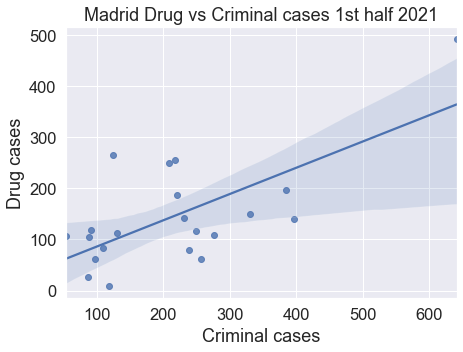

In [44]:
plt.figure(figsize=(7,5))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
ax = sns.regplot(x='Crimes', y='Drugs', data=madrid_df)
ax.set(xlabel='Criminal cases', ylabel='Drug cases')
ax.set_title('Madrid Drug vs Criminal cases 1st half 2021')
plt.show()

### VENUE EXTRACTION PER DISTRICT WITH FOURSQUARE

Part of our Madrid district analysis include the determination of the venue quantity and variety that each district holds and may help to differentiate or associate with other districts. By using the Foursquare API, and using our personal credentials we could perform a global venue search centered on each Madrid district coordinates and a radius of 1 kilometer

In [ ]:
# FOURSQUARE CREDENTIALS (UNIQUE PER USER)
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '########' # Foursquare API version, actual date for example as 'YYYYMMDD'
LIMIT = 200 # A default Foursquare API limit value

In [45]:
# The code was removed by Watson Studio for sharing.

#### Exploring Madrid disctrict venues

Firstly we will define a function that takes as input a district or neighborhood and its coordinates (latitude and longitude). Then it will adapt the Foursquare URL address customized to the user credentials and location latitude and longitude

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Before the search of disctrict venues it is necesasary to recolate the central coordinates of Fuencarral-El Pardo district because it is located in the middle of nowhere and thereby there will be no venues found. We will then relocate this district coordinates to Fuencarral Metro station.

In [47]:
#Relocate Fuencarral-El Pardo central coordinates to the address of Fuencarrral metro Station
fuencarr = 'C. de Molins de Rey, 8, 28034 Madrid, España'

geolocator = Nominatim(user_agent="MAD_explorer")
location = geolocator.geocode(fuencarr)
FUElat = location.latitude
FUElong = location.longitude
print('Coordinates of Fuencarral, Madrid: {}, {}.'.format(FUElat, FUElong))

Coordinates of Fuencarral, Madrid: 40.494763, -3.6938292.


Then we replace the original Fuencarral-El Pardo central coordinates in our main dataframe with the relocated ones and check the update on Fuencarral-El Pardo row (index 7)

In [48]:
madrid_df['LAT'] = madrid_df['LAT'].replace(madrid_df.iloc[7,3], FUElat)
madrid_df['LONG'] = madrid_df['LONG'].replace(madrid_df.iloc[7,4], FUElong)
madrid_df.iloc[7,:]

DistNumber                                                      8
District                                      Fuencarral-El Pardo
Neighborhood    [El Pardo, Fuentelarreina, Peñagrande, Pilar, ...
LAT                                                       40.4948
LONG                                                     -3.69383
meanSQM                                                      3376
SQMnormMean                                                1.0362
SQMlinNorm                                               0.429941
Crimes                                                         91
Drugs                                                         118
CrimesProp                                              0.0199737
DrugsProp                                               0.0384115
Name: 7, dtype: object

Now we can execute the NearbyVenues function to our Madrid locations in order to get the venues per district

In [49]:
madrid_venues = getNearbyVenues(madrid_df['District'], 
                                   madrid_df['LAT'], 
                                   madrid_df['LONG'])

Centro
Arganzuela
Retiro
Salamanca
Chamartín
Tetuán
Chamberí
Fuencarral-El Pardo
Moncloa-Aravaca
Latina
Carabanchel
Usera
Puente de Vallecas
Moratalaz
Ciudad Lineal
Hortaleza
Villaverde
Villa de Vallecas
Vicálvaro
San Blas-Canillejas
Barajas


In [50]:
print(madrid_venues.shape)
madrid_venues.head(10)

(1166, 7)


,District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.417653,-3.707914,Plaza de Isabel II,40.418114,-3.709397,Plaza
1,Centro,40.417653,-3.707914,Plaza Mayor,40.415527,-3.707506,Plaza
2,Centro,40.417653,-3.707914,La Esquina del Real,40.417356,-3.710364,French Restaurant
3,Centro,40.417653,-3.707914,Zen Zoo,40.416263,-3.707174,Smoothie Shop
4,Centro,40.417653,-3.707914,Torrons Vicens: Artesa D' Agramunt,40.416095,-3.708119,Pastry Shop
5,Centro,40.417653,-3.707914,Mercado de San Miguel,40.415443,-3.708943,Market
6,Centro,40.417653,-3.707914,TOC Hostel,40.417264,-3.705928,Hostel
7,Centro,40.417653,-3.707914,Cerveceria Erte,40.419241,-3.707470,Bar
8,Centro,40.417653,-3.707914,Gran Meliá Palacio de los Duques *****,40.419835,-3.709494,Hotel
9,Centro,40.417653,-3.707914,Trattoria Malatesta,40.416788,-3.707182,Italian Restaurant


We got a total of 1166 venues with our search criteria for all the districts. Now we proceeed to count how many venues we got per district

In [51]:
madrid_venues.groupby('District').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Arganzuela,100,100,100,100,100,100
Barajas,55,55,55,55,55,55
Carabanchel,19,19,19,19,19,19
Centro,100,100,100,100,100,100
Chamartín,100,100,100,100,100,100
Chamberí,100,100,100,100,100,100
Ciudad Lineal,86,86,86,86,86,86
Fuencarral-El Pardo,35,35,35,35,35,35
Hortaleza,48,48,48,48,48,48


In [52]:
Unique_ven_cat = len(madrid_venues['Venue Category'].unique())
print('There are {} uniques categories.'.format(Unique_ven_cat))

There are 198 uniques categories.


There were a total of 1166 venues and 198 different venue categories along the districts. Our next step is to count how many venues we got and how many unique categories are there present for each district. We will use this information for further analysis.

In [53]:
#Count the quantity of venues per district
venue_count=[]
venue_count = madrid_venues.groupby('District').count().iloc[:,2].reset_index()
venue_count

,District,Venue
0,Arganzuela,100
1,Barajas,55
2,Carabanchel,19
3,Centro,100
4,Chamartín,100
5,Chamberí,100
6,Ciudad Lineal,86
7,Fuencarral-El Pardo,35
8,Hortaleza,48
9,Latina,33


In [54]:
#Count the quantity of unique venue categories per district
venue_cat=[]
venue_cat= madrid_venues.groupby('District')['Venue Category'].apply(lambda x: list(np.unique(x))).reset_index().explode('Venue Category')
venue_cat= venue_cat.groupby('District').count().reset_index()
venue_cat

,District,Venue Category
0,Arganzuela,56
1,Barajas,33
2,Carabanchel,16
3,Centro,55
4,Chamartín,45
5,Chamberí,49
6,Ciudad Lineal,39
7,Fuencarral-El Pardo,28
8,Hortaleza,27
9,Latina,25


In [55]:
#Gather venue quantities and venue categories information 
venues=[]
venues = pd.merge(venue_count,venue_cat, on='District')
venues

,District,Venue,Venue Category
0,Arganzuela,100,56
1,Barajas,55,33
2,Carabanchel,19,16
3,Centro,100,55
4,Chamartín,100,45
5,Chamberí,100,49
6,Ciudad Lineal,86,39
7,Fuencarral-El Pardo,35,28
8,Hortaleza,48,27
9,Latina,33,25


Now that we have gatehered the venue quantities and venue categories information, we plot them together with Seaborn library in order to better understand the relationship between them

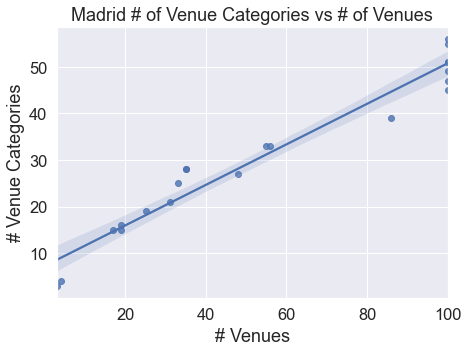

In [56]:
plt.figure(figsize=(7,5))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
ax = sns.regplot(x='Venue', y='Venue Category', data=venues)
ax.set(xlabel='# Venues', ylabel='# Venue Categories')
ax.set_title('Madrid # of Venue Categories vs # of Venues')
plt.show()

The venue quantity seem to be clipped due to Foursquare search limitations. But the venue categories don't seem to be clipped and it highly correlates with the venue quantities. Thereby, we proceed to generate a bar plot with the quantity of different venue categories per district. But first, we sort the input table in descending order

In [57]:
venues_sort = venues.sort_values('Venue Category', ascending=False).reset_index()
venues_sort

,index,District,Venue,Venue Category
0,0,Arganzuela,100,56
1,3,Centro,100,55
2,13,Retiro,100,51
3,16,Tetuán,100,51
4,5,Chamberí,100,49
5,14,Salamanca,100,47
6,4,Chamartín,100,45
7,6,Ciudad Lineal,86,39
8,17,Usera,56,33
9,1,Barajas,55,33


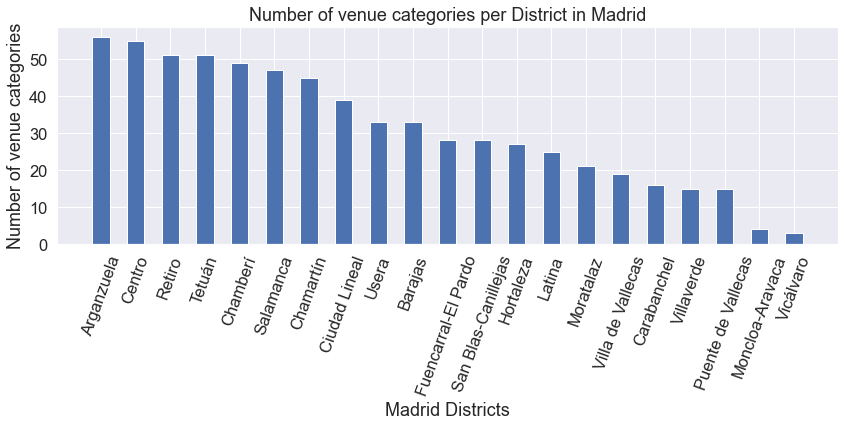

In [58]:
fig = plt.figure(figsize=(14,4))
plt.bar(venues_sort['District'], venues_sort['Venue Category'], width=0.5)
plt.xlabel('Madrid Districts')
plt.xticks(rotation=70)
plt.ylabel('Number of venue categories')
plt.title('Number of venue categories per District in Madrid')
plt.show()

The districts inside or near downtown Madrid are the ones with more variety of venues. Naturally, as we get farther from downtown the diversity becomes lower to very low.

Venue and unique venue category quantities become our new features to be incuded in our further analysis. Thereby we group them in a new feature dataframe that will include the previous real estate and security features

In [59]:
madrid_features = []
madrid_features = madrid_df[['District','meanSQM','Crimes','Drugs']]
madrid_features = pd.merge(madrid_features, venues, how='inner', on='District')
#print(madrid_features.shape)
madrid_features

,District,meanSQM,Crimes,Drugs,Venue,Venue Category
0,Centro,4707.0,641,493,100,55
1,Arganzuela,3939.0,98,62,100,56
2,Retiro,4474.5,54,106,100,51
3,Salamanca,5605.5,330,150,100,47
4,Chamartín,4802.5,89,105,100,45
5,Tetuán,3548.5,238,80,100,51
6,Chamberí,5126.0,131,113,100,49
7,Fuencarral-El Pardo,3376.0,91,118,35,28
8,Moncloa-Aravaca,3806.0,277,109,4,4
9,Latina,2218.5,209,250,33,25


In [60]:
#Check that the data types are numeric (float or integer)
madrid_features.dtypes

District           object
meanSQM           float64
Crimes              int64
Drugs               int64
Venue               int64
Venue Category      int64
dtype: object

Also, we can update our main dataframe the the new venue features:

In [61]:
madrid_df = pd.merge(madrid_df, venues, how='left', on='District')
#print(madrid_features.shape)
madrid_df

,DistNumber,District,Neighborhood,LAT,LONG,meanSQM,SQMnormMean,SQMlinNorm,Crimes,Drugs,CrimesProp,DrugsProp,Venue,Venue Category
0,1,Centro,"[Palacio, Embajadores, Cortes, Justicia, Unive...",40.417653,-3.707914,4707.0,1.444720,0.770263,641,493,0.140694,0.160482,100,55
1,2,Arganzuela,"[Imperial, Acacias, Chopera, Legazpi, Delicias...",40.396954,-3.697289,3939.0,1.208997,0.573894,98,62,0.021510,0.020182,100,56
2,3,Retiro,"[ Pacífico, Adelfas, Estrella, Ibiza, Jerónimo...",40.411150,-3.676057,4474.5,1.373358,0.710816,54,106,0.011853,0.034505,100,51
3,4,Salamanca,"[Recoletos, Goya, Fuente del Berro, Guindalera...",40.427045,-3.680602,5605.5,1.720496,1.000000,330,150,0.072432,0.048828,100,47
4,5,Chamartín,"[El Viso, Prosperidad, Ciudad Jardín, Hispanoa...",40.458987,-3.676129,4802.5,1.474032,0.794682,89,105,0.019535,0.034180,100,45
5,6,Tetuán,"[Bellas Vistas, Cuatro Caminos, Castillejos, A...",40.460578,-3.698281,3548.5,1.089141,0.474048,238,80,0.052239,0.026042,100,51
6,7,Chamberí,"[Gaztambide, Arapiles, Trafalgar, Almagro, Río...",40.436247,-3.703830,5126.0,1.573323,0.877397,131,113,0.028753,0.036784,100,49
7,8,Fuencarral-El Pardo,"[El Pardo, Fuentelarreina, Peñagrande, Pilar, ...",40.494763,-3.693829,3376.0,1.036196,0.429941,91,118,0.019974,0.038411,35,28
8,9,Moncloa-Aravaca,"[Casa de Campo, Argüelles, Ciudad Universitari...",40.439495,-3.744204,3806.0,1.168176,0.539887,277,109,0.060799,0.035482,4,4
9,10,Latina,"[Los Cármenes, Puerta del Ángel, Lucero, Aluch...",40.403532,-3.736152,2218.5,0.680924,0.133981,209,250,0.045874,0.081380,33,25


### Multilinear regression

At this point we have already processed for each district parameters like criminal cases, drug cases, average square meter price, number of venues and number of venue categories. Our next analysis step will be to generate some multilinear models with the purpose of understanding how different features could affect the area values of each district.

But first we need to observe the inter relationship among the selected features. To easily do this we generate a Seaborn pairplot with all the selected features. To achieve this step we don't need the districts

In [62]:
mad_features_only = madrid_features[['meanSQM','Crimes','Drugs','Venue','Venue Category']]
mad_features_only

,meanSQM,Crimes,Drugs,Venue,Venue Category
0,4707.0,641,493,100,55
1,3939.0,98,62,100,56
2,4474.5,54,106,100,51
3,5605.5,330,150,100,47
4,4802.5,89,105,100,45
5,3548.5,238,80,100,51
6,5126.0,131,113,100,49
7,3376.0,91,118,35,28
8,3806.0,277,109,4,4
9,2218.5,209,250,33,25


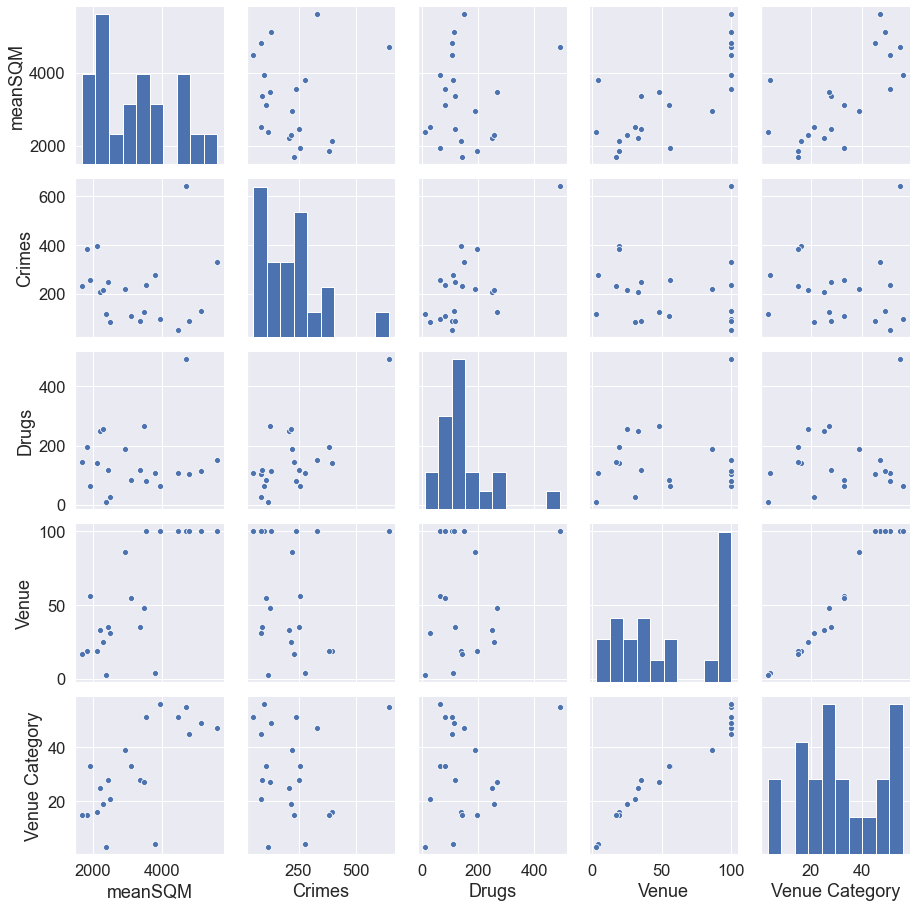

In [63]:
sns.pairplot(mad_features_only)

In most of the cases, the correlations were not very clear. The area prices appear to be more correlated to the quantity of venues and the variety of venues. Also, the area prices seem to be inversely correlated to the crime quantities. Crime and drug cases seem to have some degree of correlation. Number of venues and venue categories show strong correlation between then.
Since we have several parameters, we are going to test some multilinear models where we try to predict the square meter price per district based on security flaws, drug cases and venues

***Model 1: All the features***

We begin modeling all our features in order to observe how they behave

In [64]:
regr=linear_model.LinearRegression()
x=np.asanyarray(madrid_features[['Crimes','Drugs','Venue','Venue Category']])
y=np.asanyarray(madrid_features[['meanSQM']])
regr.fit(x,y)
# The coefficients
print('Coefficients: ',regr.coef_)
print('Intercept: ',regr.intercept_)
print('Variance score: %.2f' %regr.score(x,y))

Coefficients:  [[ -0.64387148   1.5255613   55.3718756  -73.14628878]]
Intercept:  [2399.01894308]
Variance score: 0.64


This model with a modest variance score suggests that the prices are positively influenced by the drug cases and number of venues and negatively influenced by the crimes and variety of venues. This doesn’t seem very logic since we previously saw that the number of venue categories showed a positive trend with the area prices. This could be explained by the fact that the independent variables number of venues and venue categories have collinearity between them. We then stay with one of them.

***Model 2: Crimes, drugs and venue categories***

We chose to stay with venue category variable because the number of venue variable showed evidence of clipping that affects the linear correlation

In [65]:
regr2=linear_model.LinearRegression()
x2=np.asanyarray(madrid_features[['Crimes','Drugs','Venue Category']])
y2=np.asanyarray(madrid_features[['meanSQM']])
regr2.fit(x2,y2)
# The coefficients
print('Coefficients: ',regr2.coef_)
print('Intercept: ',regr2.intercept_)
print('Variance score: %.2f' %regr2.score(x2,y2))

Coefficients:  [[-0.59706497  0.6596417  49.11058566]]
Intercept:  [1747.63438778]
Variance score: 0.49


The variance score dropped to nearly 50% where the price is explained to be considerably benefited from a greater variety of venue categories, negatively affected by the crime occurrences and positively from drug cases. Since we previously saw some degree of correlation between crimes and drugs, we proceed to our next model even simpler were we stay with one of this criminal categories.

***Model 3: Crimes and venue categories***

We favored in this case the number of crimes, since it visually better correlates with property prices and we consider that crimes negatively affect more the people’s willingness to invest in specific locations than the drug cases.

In [66]:
regr3=linear_model.LinearRegression()
x3=np.asanyarray(madrid_features[['Crimes', 'Venue Category']])
y3=np.asanyarray(madrid_features[['meanSQM']])
regr3.fit(x3,y3)
# The coefficients
print('Coefficients: ',regr3.coef_)
print('Intercept: ',regr3.intercept_)
print('Variance score: %.2f' %regr3.score(x3,y3))

Coefficients:  [[-0.25789678 49.84272906]]
Intercept:  [1747.5369784]
Variance score: 0.49


Our third model was simpler but as accurate as the second model. It suggests that for every new crime the average square meter price drops by 0.25 euros. On the other hand, for every new venue category present in a district, the square meter price increases 49.8 euros. This model gives us as qualitative insights that Madrid districts are valorized to a greater scale by the presence of more variety of options for the residents and visitors and slightly affected by the occurrence of incidents that require police intervention

### K-MEANS Clustering

Once finished the linear regression tests and analysis we proceed to the clustering analysis. The purpose of this analytic method is to group the districts into different classes according their different features such as property prices, safety and drug indicators, total and variety of venues and the quantity of each venue type. We choose the K-means method because it allows us to determine the quantity of classes we want the different districts to be grouped at. But this number of classes should be fair enough to guarantee that the classification and inertia (measures of how big are the Euclidean distances between points and cluster centroids inside each cluster). That is, the districts within a class should be as similar as possible within a class. We will performe some tests with the Elbow method to select a number of classes high enough to reduce the Euclidean distances of the clusters and low enough to guarantee a number of classes significantly lower than the total of samples (districts in our case).

#### Clustering preprocessing

Prior to our clustering steps we still need to prepare the input data. We need to determine the proportions of each venue category per district. 

It is then necessary to create a one-hot encoded database of Madrid venue categories. It will transform each venue category to a column feauture. Each particular venue will correspond to 1 value in its corresponding category and 0 in the rest of non corresponding venues. 

In [67]:
madrid_onehot =[]
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# There was a 'neighborhood' category that we are not interested at. Thereby we remove it
#madrid_onehot = madrid_onehot.drop(columns=['Neighborhood'], axis=1, inplace=True)

# add district column back to dataframe
madrid_onehot['District'] = madrid_venues['District'] 

# move district column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

print(madrid_onehot.shape)
madrid_onehot.head()

(1166, 199)


,District,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Design Studio,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Service,Food Stand,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Other Great Outdoors,Other Nightlife,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Rental Service,Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Track Stadium,Trade School,Train Station,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Now we group the venue categories by district and estimate their mean. As result, we will have fractions of venue categories per district 

In [68]:
madrid_grouped = madrid_onehot.groupby('District').mean().reset_index()
madrid_grouped

,District,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Design Studio,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Service,Food Stand,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Other Great Outdoors,Other Nightlife,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Rental Service,Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Track Stadium,Trade School,Train Station,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Arganzuela,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.020000,0.02,0.01,0.00,0.010000,0.000000,0.000000,0.010000,0.040000,0.030000,0.00,0.010000,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.020000,0.00,0.000000,0.010000,0.010000,0.000000,0.00,0.020000,0.00,0.00,0.01,0.000000,0.010000,0.020000,0.00,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.020000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.01,0.000000,0.020000,0.00,0.000000,0.00,0.040000,0.030000,0.020000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.020000,0.00,0.01,0.03,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.03,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.030000,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.00,0.010000,0.000000,0.010000,0.000000,0.00,0.00,0.00,0.070000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.0

Additionally, we proceed to generate a table with the most common venues per district

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [70]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['District'] = madrid_grouped['District']

for ind in np.arange(madrid_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

location_venues_sorted.head(19)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Spanish Restaurant,Restaurant,Tapas Restaurant,Grocery Store,Bakery,Park,Gym,Bar,Market,Indie Theater
1,Barajas,Hotel,Spanish Restaurant,Restaurant,Airport Service,Tapas Restaurant,Coffee Shop,Snack Place,Duty-free Shop,Breakfast Spot,Argentinian Restaurant
2,Carabanchel,Tapas Restaurant,Restaurant,Spanish Restaurant,Candy Store,Supermarket,Bakery,Café,BBQ Joint,Cafeteria,Athletics & Sports
3,Centro,Plaza,Tapas Restaurant,Spanish Restaurant,Hotel,Café,Hostel,Bookstore,Bar,Pastry Shop,Gourmet Shop
4,Chamartín,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Plaza,Bar,Grocery Store,Pizza Place,Tapas Restaurant,Gastropub,Japanese Restaurant
5,Chamberí,Tapas Restaurant,Café,Bar,Spanish Restaurant,Restaurant,Theater,Ice Cream Shop,Plaza,Japanese Restaurant,Italian Restaurant
6,Ciudad Lineal,Spanish Restaurant,Grocery Store,Restaurant,Park,Chinese Restaurant,Hotel,Italian Restaurant,Café,Bar,Pharmacy
7,Fuencarral-El Pardo,Restaurant,Spanish Restaurant,Soccer Field,Bar,Wine Shop,Tapas Restaurant,Salad Place,Fast Food Restaurant,Metro Station,Bookstore
8,Hortaleza,Spanish Restaurant,Supermarket,Restaurant,Tapas Restaurant,Sandwich Place,Pizza Place,Plaza,Soup Place,Irish Pub,Coffee Shop
9,Latina,Grocery Store,Park,Pizza Place,Bar,Supermarket,Fast Food Restaurant,Bowling Alley,Sandwich Place,Bakery,Food


This "most common venues per district" table will be used later to discuss the results of the K-means clustering steps

For the clustering excercises, we are going to use as input features the grouped one hot matrix which is already normalized. But first we need to drop the neighborhood column. Given that we will not loose the order of the samples, once finished the clustering steps we can return the District information.

In [71]:
madrid_grouped_clustering = madrid_grouped.drop('District', axis=1)
madrid_grouped_clustering

,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Design Studio,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Service,Food Stand,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Other Great Outdoors,Other Nightlife,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Rental Service,Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Track Stadium,Trade School,Train Station,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.020000,0.02,0.01,0.00,0.010000,0.000000,0.000000,0.010000,0.040000,0.030000,0.00,0.010000,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.020000,0.00,0.000000,0.010000,0.010000,0.000000,0.00,0.020000,0.00,0.00,0.01,0.000000,0.010000,0.020000,0.00,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.020000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.01,0.000000,0.020000,0.00,0.000000,0.00,0.040000,0.030000,0.020000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.020000,0.00,0.01,0.03,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.03,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.030000,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.00,0.010000,0.000000,0.010000,0.000000,0.00,0.00,0.00,0.070000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,

Also we will use as feauture inputs the normalized and proportional safety and real estate attributes that we estimated in the previous steps

In [72]:
madrid_grouped_clustering['SQMlinNorm'] = SQM_linNorm
madrid_grouped_clustering['CrimesProp'] = CrimesProp
madrid_grouped_clustering['DrugsProp'] = DrugsProp
madrid_grouped_clustering['VenueCatProp'] = madrid_features['Venue Category']/Unique_ven_cat
madrid_grouped_clustering

,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Design Studio,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Service,Food Stand,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Other Great Outdoors,Other Nightlife,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Rental Service,Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Track Stadium,Trade School,Train Station,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,SQMlinNorm,CrimesProp,DrugsProp,VenueCatProp
0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.020000,0.02,0.01,0.00,0.010000,0.000000,0.000000,0.010000,0.040000,0.030000,0.00,0.010000,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.020000,0.00,0.000000,0.010000,0.010000,0.000000,0.00,0.020000,0.00,0.00,0.01,0.000000,0.010000,0.020000,0.00,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.020000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.01,0.000000,0.020000,0.00,0.000000,0.00,0.040000,0.030000,0.020000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.020000,0.00,0.01,0.03,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.03,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.030000,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.00,0.010000,0.000000,0.010000,0.000000,0.00,0.00,0.00,0.070000,0.000000,0.000000,0.000000,0

***K-MEANS Clustering tests***

K-Means clustering requires as input the number of clusters we want to create. But at this point we don't know what numnber is more optimal. It should be fair enough to guarantee that the classification and inertia (measures of how big are the Euclidean distances between points and cluster centroids inside each cluster). That is, the districts within a class should be as similar as possible within a class

Therefore, we are going to apply the elbow method test to find a relatively low k value from where the optimization will not improve significantly. We are going to observe how big the distorsion and inertia are for each k number. These measures indicate how big the cumulative Euclidean distances between data points and cluster centroids are on the feature hyperspace. The ideal k should be that from were the distorsions and/or inertias don't reduce significantly.

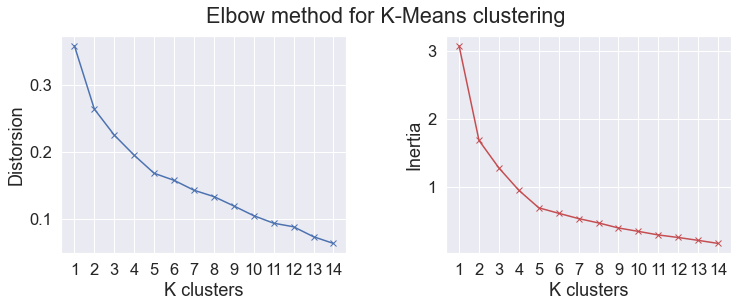

In [73]:
distortions =[] #list of average of squared distances from cluster centers 
inertias = [] #list of sum of squared distances of samples to cluster centers
K = range(1,15)

for k in K:
    kmeanmod = KMeans(n_clusters=k, random_state=0).fit(madrid_grouped_clustering)
    distortions.append(sum(np.min(cdist(madrid_grouped_clustering, kmeanmod.cluster_centers_,'euclidean'), axis=1)) / madrid_grouped_clustering.shape[0])
    inertias.append(kmeanmod.inertia_)
# ELBOW METHOD PLOTS
plt.figure(figsize=(12,4))
#Left plot
plt.subplot(1,2,1)
plt.plot(K, distortions, 'bx-')
plt.xticks(np.arange(1, 15, step=1))
plt.xlabel('K clusters')
plt.ylabel('Distorsion')
#Right plot
plt.subplot(1,2,2)
plt.plot(K, inertias, 'rx-')
plt.xticks(np.arange(1, 15, step=1))
plt.xlabel('K clusters')
plt.ylabel('Inertia')
#General title
plt.suptitle('Elbow method for K-Means clustering')
plt.subplots_adjust(wspace=0.35)
plt.show()

Observing the results we see that from the distorsion perspective, k beyond 9 does not drop it considerably. We abserve a distortion elbow at k=5, but in my opinion its value is still slightly high. After observing the inertia plot, we find a more remarkable elbow at k=5. Beyond that value, inertia starts to drop more slowly. 

From these two plots we decide that 7 would be a fair number of clusters that will assure us relatively low distorsion and inertia values, lower than elbow values. Also 7 is the third of the total number of Madrid districts, 21. We would then expect about 3 districts per class.

In [74]:
# set number of clusters
kclusters = 7

#madrid_grouped_clustering = madrid_grouped_clustering.drop('PostalCode', 1) #Uncomment if the elbow test cell was skiped

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([5, 6, 6, 2, 2, 2, 6, 3, 3, 1, 4, 1, 1, 2, 2, 1, 3, 1, 0, 1])

From the clustering process we obtain class labels that we will then append to our most common venues per district table 

In [75]:
# add clustering labels
location_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
location_venues_sorted.head(10)

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,Arganzuela,Spanish Restaurant,Restaurant,Tapas Restaurant,Grocery Store,Bakery,Park,Gym,Bar,Market,Indie Theater
1,6,Barajas,Hotel,Spanish Restaurant,Restaurant,Airport Service,Tapas Restaurant,Coffee Shop,Snack Place,Duty-free Shop,Breakfast Spot,Argentinian Restaurant
2,6,Carabanchel,Tapas Restaurant,Restaurant,Spanish Restaurant,Candy Store,Supermarket,Bakery,Café,BBQ Joint,Cafeteria,Athletics & Sports
3,2,Centro,Plaza,Tapas Restaurant,Spanish Restaurant,Hotel,Café,Hostel,Bookstore,Bar,Pastry Shop,Gourmet Shop
4,2,Chamartín,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Plaza,Bar,Grocery Store,Pizza Place,Tapas Restaurant,Gastropub,Japanese Restaurant
5,2,Chamberí,Tapas Restaurant,Café,Bar,Spanish Restaurant,Restaurant,Theater,Ice Cream Shop,Plaza,Japanese Restaurant,Italian Restaurant
6,6,Ciudad Lineal,Spanish Restaurant,Grocery Store,Restaurant,Park,Chinese Restaurant,Hotel,Italian Restaurant,Café,Bar,Pharmacy
7,3,Fuencarral-El Pardo,Restaurant,Spanish Restaurant,Soccer Field,Bar,Wine Shop,Tapas Restaurant,Salad Place,Fast Food Restaurant,Metro Station,Bookstore
8,3,Hortaleza,Spanish Restaurant,Supermarket,Restaurant,Tapas Restaurant,Sandwich Place,Pizza Place,Plaza,Soup Place,Irish Pub,Coffee Shop
9,1,Latina,Grocery Store,Park,Pizza Place,Bar,Supermarket,Fast Food Restaurant,Bowling Alley,Sandwich Place,Bakery,Food


Then we merge the previous table with the main dataframe which had already integrated the previously selected real state, security and venue feautures

In [76]:
madrid_merged = madrid_df

# merge our Madrid neighborhood table with the sorted venue table that now includes cluster labels
madrid_merged = madrid_merged.join(location_venues_sorted.set_index('District'), on='District', how='inner')

print(madrid_merged.shape)
madrid_merged.head(15) # check the table

(21, 25)


,DistNumber,District,Neighborhood,LAT,LONG,meanSQM,SQMnormMean,SQMlinNorm,Crimes,Drugs,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Centro,"[Palacio, Embajadores, Cortes, Justicia, Unive...",40.417653,-3.707914,4707.0,1.444720,0.770263,641,493,0.140694,0.160482,100,55,2,Plaza,Tapas Restaurant,Spanish Restaurant,Hotel,Café,Hostel,Bookstore,Bar,Pastry Shop,Gourmet Shop
1,2,Arganzuela,"[Imperial, Acacias, Chopera, Legazpi, Delicias...",40.396954,-3.697289,3939.0,1.208997,0.573894,98,62,0.021510,0.020182,100,56,5,Spanish Restaurant,Restaurant,Tapas Restaurant,Grocery Store,Bakery,Park,Gym,Bar,Market,Indie Theater
2,3,Retiro,"[ Pacífico, Adelfas, Estrella, Ibiza, Jerónimo...",40.411150,-3.676057,4474.5,1.373358,0.710816,54,106,0.011853,0.034505,100,51,2,Spanish Restaurant,Bar,Italian Restaurant,Brewery,Hotel,Tapas Restaurant,Supermarket,Gym,Garden,Bakery
3,4,Salamanca,"[Recoletos, Goya, Fuente del Berro, Guindalera...",40.427045,-3.680602,5605.5,1.720496,1.000000,330,150,0.072432,0.048828,100,47,2,Spanish Restaurant,Restaurant,Italian Restaurant,Clothing Store,Boutique,Burger Joint,Hotel,Tapas Restaurant,Furniture / Home Store,Mexican Restaurant
4,5,Chamartín,"[El Viso, Prosperidad, Ciudad Jardín, Hispanoa...",40.458987,-3.676129,4802.5,1.474032,0.794682,89,105,0.019535,0.034180,100,45,2,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Plaza,Bar,Grocery Store,Pizza Place,Tapas Restaurant,Gastropub,Japanese Restaurant
5,6,Tetuán,"[Bellas Vistas, Cuatro Caminos, Castillejos, A...",40.460578,-3.698281,3548.5,1.089141,0.474048,238,80,0.052239,0.026042,100,51,3,Spanish Restaurant,Restaurant,Chinese Restaurant,Hotel,Supermarket,Japanese Restaurant,Pub,Burger Joint,Paella Restaurant,Brazilian Restaurant
6,7,Chamberí,"[Gaztambide, Arapiles, Trafalgar, Almagro, Río...",40.436247,-3.703830,5126.0,1.573323,0.877397,131,113,0.028753,0.036784,100,49,2,Tapas Restaurant,Café,Bar,Spanish Restaurant,Restaurant,Theater,Ice Cream Shop,Plaza,Japanese Restaurant,Italian Restaurant
7,8,Fuencarral-El Pardo,"[El Pardo, Fuentelarreina, Peñagrande, Pilar, ...",40.494763,-3.693829,3376.0,1.036196,0.429941,91,118,0.019974,0.038411,35,28,3,Restaurant,Spanish Restaurant,Soccer Field,Bar,Wine Shop,Tapas Restaurant,Salad Place,Fast Food Restaurant,Metro Station,Bookstore
8,9,Moncloa-Aravaca,"[Casa de Campo, Argüelles, Ciudad Universitari...",40.439495,-3.744204,3806.0,1.168176,0.539887,277,109,0.060799,0.035482,4,4,4,Hookah Bar,College Cafeteria,Park,Tennis Court,Wine Shop,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
9,10,Latina,"[Los Cármenes, Puerta del Ángel, Lucero, Aluch...",40.403532,-3.736152,2218.5,0.680924,0.133981,209,250,0.045874,0.081380,33,25,1,Grocery Store,Park,Pizza Place,Bar,Supermarket,Fast Food Restaurant,Bowling Alley,Sandwich Place,Bakery,Food


Then we proceeded to map the district classes as markers in Folium maps over choropleth maps of square meter prices and crimes per district

In [77]:
# create map
map_clusters = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# generate choropleth map using the average square meter price per district of Madrid
map_clusters.choropleth(
    geo_data=madrid_geo,
    data=madrid_merged,
    columns=['District', 'meanSQM'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average m2 value',
    reset = True #run if you perform more than one test
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['LAT'], madrid_merged['LONG'], madrid_merged['District'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

C:\programs\anaconda3\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [78]:
# create map
map_clusters2 = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# generate choropleth map using crime cases per district of Madrid
map_clusters2.choropleth(
    geo_data=madrid_geo,
    data=madrid_merged,
    columns=['District', 'Crimes'],
    key_on='feature.properties.nombre',
    fill_color='Reds', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Criminal cases 1st half 2021',
    reset = True #run if you perform more than one test
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['LAT'], madrid_merged['LONG'], madrid_merged['District'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

In [79]:
# create map
map_clusters3 = folium.Map(width='90%', height='90%', location=[MADlat, MADlong], zoom_start=10)

# generate choropleth map using the number of different venue categories per district of Madrid
map_clusters3.choropleth(
    geo_data=madrid_geo,
    data=madrid_merged,
    columns=['District', 'Venue Category'],
    key_on='feature.properties.nombre',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Different venue categories',
    reset = True #run if you perform more than one test
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['LAT'], madrid_merged['LONG'], madrid_merged['District'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)
       
map_clusters3

Visually we realize that most of the central districts, the ones with the most expensive unit areas, share the same class. There is a class that gathers most of the southern districts and part of the eastern ones, which show average to below-average unit area prices, intermediate amount of different venue categories and intermediate to high crime indicators. The northern districts are gathered in two classes which have intermediate unit area values, relatively low crime indicators and intermediate to high numbers of different venue categories. There are three single-district classes and two with five or more districts gathered.

***Classification result analysis***

In [80]:
# CLUSTER 1
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Vicálvaro,0.731875,0.026119,0.00293,3,3,0,Construction & Landscaping,Mediterranean Restaurant,Toll Booth,Wine Shop,Duty-free Shop,Food & Drink Shop,Food,Flea Market,Fish Market,Fast Food Restaurant


Vicalvaro is an easterly border district with the lowest variety of venues, property values below the average and one of the lowest crime rates. This district is in growth. It has a relatively new university and urbanistic development in progress. We might see in the near future a different picture of this district, with new venue opportunities and property revalorization.

In [81]:
# CLUSTER 2
This cluster gathers most of the northern districts which are characterized by average unit are prices, intermediate to high venue varieties that include international restaurants, supermarkets, hotels and parks and relatively low criminal and drug cases. We could consider it a “middle class” cluster. People willing to taste different local and exotic flavors, do sports and invest with intermediate housing budget seem to fit better in these cluster districtsmadrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Latina,0.680924,0.045874,0.081380,33,25,1,Grocery Store,Park,Pizza Place,Bar,Supermarket,Fast Food Restaurant,Bowling Alley,Sandwich Place,Bakery,Food
11,Usera,0.592375,0.056409,0.020182,56,33,1,Spanish Restaurant,Beer Garden,Grocery Store,Seafood Restaurant,Coffee Shop,Bar,Bakery,Fast Food Restaurant,Clothing Store,Gastropub
12,Puente de Vallecas,0.569202,0.084284,0.064128,19,15,1,Clothing Store,Park,Bar,Supermarket,Grocery Store,Concert Hall,Sandwich Place,Fast Food Restaurant,Shopping Mall,Spanish Restaurant
13,Moratalaz,0.772850,0.019096,0.008789,31,21,1,Park,Bar,Bakery,Café,Pizza Place,Playground,Plaza,Skating Rink,Soccer Field,Metro Station
16,Villaverde,0.520093,0.050702,0.046549,17,15,1,Metro Station,Spanish Restaurant,Pizza Place,Grocery Store,Brewery,Mediterranean Restaurant,Bus Station,Electronics Store,Furniture / Home Store,Gastropub
17,Villa de Vallecas,0.703944,0.047629,0.083333,25,19,1,Tapas Restaurant,Pizza Place,Gym,Restaurant,Soccer Field,Spanish Restaurant,Pharmacy,Church,Pet Store,Plaza
19,San Blas-Canillejas,0.755662,0.054873,0.037760,35,28,1,Grocery Store,Pizza Place,Tapas Restaurant,Gym,Seafood Restaurant,Playground,Soccer Stadium,Sports Club,Sporting Goods Shop,Spanish Restaurant


This class gathers most of the southern and eastern districts of Madrid, which are characterized by property prices below the city average, intermediate to high criminal case reports and an intermediate variety of venues that include parks, local restaurants, pizza places, markets and sport businesses. This is more a “working-class” cluster. This is a popular group for people who are willing to live and enjoy of areas with good variety of options for eating, purchasing and recreation. They should to take some security precautions, but not as if they were in Centro (downtown).

In [82]:
# CLUSTER 3
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,1.444720,0.140694,0.160482,100,55,2,Plaza,Tapas Restaurant,Spanish Restaurant,Hotel,Café,Hostel,Bookstore,Bar,Pastry Shop,Gourmet Shop
2,Retiro,1.373358,0.011853,0.034505,100,51,2,Spanish Restaurant,Bar,Italian Restaurant,Brewery,Hotel,Tapas Restaurant,Supermarket,Gym,Garden,Bakery
3,Salamanca,1.720496,0.072432,0.048828,100,47,2,Spanish Restaurant,Restaurant,Italian Restaurant,Clothing Store,Boutique,Burger Joint,Hotel,Tapas Restaurant,Furniture / Home Store,Mexican Restaurant
4,Chamartín,1.474032,0.019535,0.034180,100,45,2,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Plaza,Bar,Grocery Store,Pizza Place,Tapas Restaurant,Gastropub,Japanese Restaurant
6,Chamberí,1.573323,0.028753,0.036784,100,49,2,Tapas Restaurant,Café,Bar,Spanish Restaurant,Restaurant,Theater,Ice Cream Shop,Plaza,Japanese Restaurant,Italian Restaurant


This cluster includes the most centric and expensive districts of Madrid. They also have a high to very high variety of venues including typical restaurants, bars, cafés, hotels, gastropubs, shops, etc. Most of Madrid’s tourist activity and transit lies in this cluster. Unsafety and drug occurrences are mixed. But includes Madrid Centro, which is the district with more criminal and drug cases. It is logic due to the intense tourist transit and associated amusement options.

In [83]:
# CLUSTER 4
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Tetuán,1.089141,0.052239,0.026042,100,51,3,Spanish Restaurant,Restaurant,Chinese Restaurant,Hotel,Supermarket,Japanese Restaurant,Pub,Burger Joint,Paella Restaurant,Brazilian Restaurant
7,Fuencarral-El Pardo,1.036196,0.019974,0.038411,35,28,3,Restaurant,Spanish Restaurant,Soccer Field,Bar,Wine Shop,Tapas Restaurant,Salad Place,Fast Food Restaurant,Metro Station,Bookstore
15,Hortaleza,1.069037,0.027436,0.086589,48,27,3,Spanish Restaurant,Supermarket,Restaurant,Tapas Restaurant,Sandwich Place,Pizza Place,Plaza,Soup Place,Irish Pub,Coffee Shop


This class gathers most of the northern districts which are characterized by average unit are prices, intermediate to high venue varieties that include traditional and international restaurants, spirits businesses and supermarkets. and relatively low criminal and drug cases. We could consider it a “middle class” cluster. People willing to taste different local and exotic flavors, have fun and invest with intermediate housing budget seem to fit better in this class of districts.

In [84]:
# CLUSTER 5
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Moncloa-Aravaca,1.168176,0.060799,0.035482,4,4,4,Hookah Bar,College Cafeteria,Park,Tennis Court,Wine Shop,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market


This could be tagged as the green cluster of Madrid, which only includes Moncloa-Aravaca district. There are not so many variety of places of interest, compared to its neighbor districts, but they include many green areas and parks, including the famous Casa de Campo park. The property prices are above Madrid’s average. Despite the district’s average property price is not as high as the central district prices (cluster 3), the neighborhood of Aravaca holds some of the most expensive and largest Madrid houses.

In [85]:
# CLUSTER 6
madrid_merged.loc[madrid_merged['Cluster Labels'] == 5, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arganzuela,1.208997,0.02151,0.020182,100,56,5,Spanish Restaurant,Restaurant,Tapas Restaurant,Grocery Store,Bakery,Park,Gym,Bar,Market,Indie Theater


It only includes Arguanzuela district, which is located next south of the central district. With property values above the average, it counts on a wide variety of venues, mainly typical restaurants and a mix of market types and recreation venues such as gyms, parks and bars.

In [86]:
# CLUSTER 7
madrid_merged.loc[madrid_merged['Cluster Labels'] == 6, madrid_merged.columns[[1]+[6]+ list(range(10, madrid_merged.shape[1]))]]

,District,SQMnormMean,CrimesProp,DrugsProp,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Carabanchel,0.656677,0.087138,0.045573,19,16,6,Tapas Restaurant,Restaurant,Spanish Restaurant,Candy Store,Supermarket,Bakery,Café,BBQ Joint,Cafeteria,Athletics & Sports
14,Ciudad Lineal,0.903449,0.048507,0.060872,86,39,6,Spanish Restaurant,Grocery Store,Restaurant,Park,Chinese Restaurant,Hotel,Italian Restaurant,Café,Bar,Pharmacy
20,Barajas,0.955473,0.024144,0.027018,55,33,6,Hotel,Spanish Restaurant,Restaurant,Airport Service,Tapas Restaurant,Coffee Shop,Snack Place,Duty-free Shop,Breakfast Spot,Argentinian Restaurant


The majority of the districts included in this class, Ciudad Lineal and Barajas, are also northern districts similar to those of cluster 4 (label 3), except that these are cheaper and have more traditional restaurants, hotels, grocery stores and cafes than the other northern cluster that has more specialized businesses. We also see included in this cluster the southern district of Carabanchel, which has a more popular profile, probably better associated with the southern disctricts of class 2. However, what  Carabanchel has more in common with this group's northern districts is a greater proportion of Spanish, tapas and other types of restaurants, as well as coffee businesses.

### CONCLUSIONS

Linear regression analytic method helped us understand the greater and lesser impact of the different district categories that could be affecting the property value performance of each district. More robust models for predicting purposes should include more internal and external variables and probably focus more on specific neighborhoods.

According to the results, venue diveristy has a stronger, positive, impact on the district property values. Security problems seem to have a subtle negative impact on them.

The K-means clustering methods did a good work identifying similar districts mainly by their property values, variety of venues, more frequent venues and to a lesser degree, the criminal and drug-type incidents. The classes most of the times followed a geographically continuous pattern, linked to the intrinsic district feautures.

Northern Madrid districts have more middle class profile with average property prices and good venue diversity and security indicators. Central districts are considerably more expensive, full of venues but also with the most security problems. Southern district have a more popular profile but they also count of average venue diversity and security issues. West part is full of green and open recreational places. East part is a growing area of the Spanish capital.

More accurate models and prediction would require more category considerations, internal and external, and neighborhood focusing on specific districts.